In [1]:
import re
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import cellrank as cr
from scipy import sparse
from anndata import AnnData
import matplotlib.cm as cm
import os

sc.set_figure_params(dpi=100, color_map='viridis', fontsize=6)
sc.settings.verbosity=2
sc.settings.n_jobs=16
cr.settings.verbosity = 2
scv.settings.verbosity = 3
#sc.logging.print_versions()

stype = "CD8"
oDir = os.path.abspath("./OUT_FigS20")

if not os.path.exists(oDir):
    os.makedirs(oDir)
os.chdir(oDir)

In [2]:
adata = sc.read(f"{oDir}/../../data/velo/adata_{stype}.h5ad")

In [3]:
## subset & add reduction
redim1 = pd.read_csv(f"{oDir}/../../data/metaInfo/{stype}_ovTex.umap.txt.gz", compression="gzip", sep="\t", header=0, index_col=0)
over = list(set(redim1.index) & set(adata.obs_names))
adata=adata[over,]
redim1 = redim1.loc[over,:]
#
adata.obsm['X_UMAP'] = np.array(redim1) 

In [4]:
## add exprGroup
group = pd.read_csv(f"{oDir}/../../data/metaInfo/{stype}_ovTex.exprGroup.txt.gz", compression="gzip", sep="\t", header=None, index_col=0)
adata.obs['group'] = group.loc[list(adata.obs_names),:]

# scVelo

In [5]:
scv.pp.filter_and_normalize(adata, min_shared_cells=1, log=True)

Filtered out 27909 genes that are detected in less than 1 cells (shared).
Normalized count data: X, spliced, unspliced.
Logarithmized X.


calculating cell cycle phase
computing score 'S_score'
    finished (0:00:00)
computing score 'G2M_score'
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)


... storing 'group' as categorical
... storing 'phase' as categorical


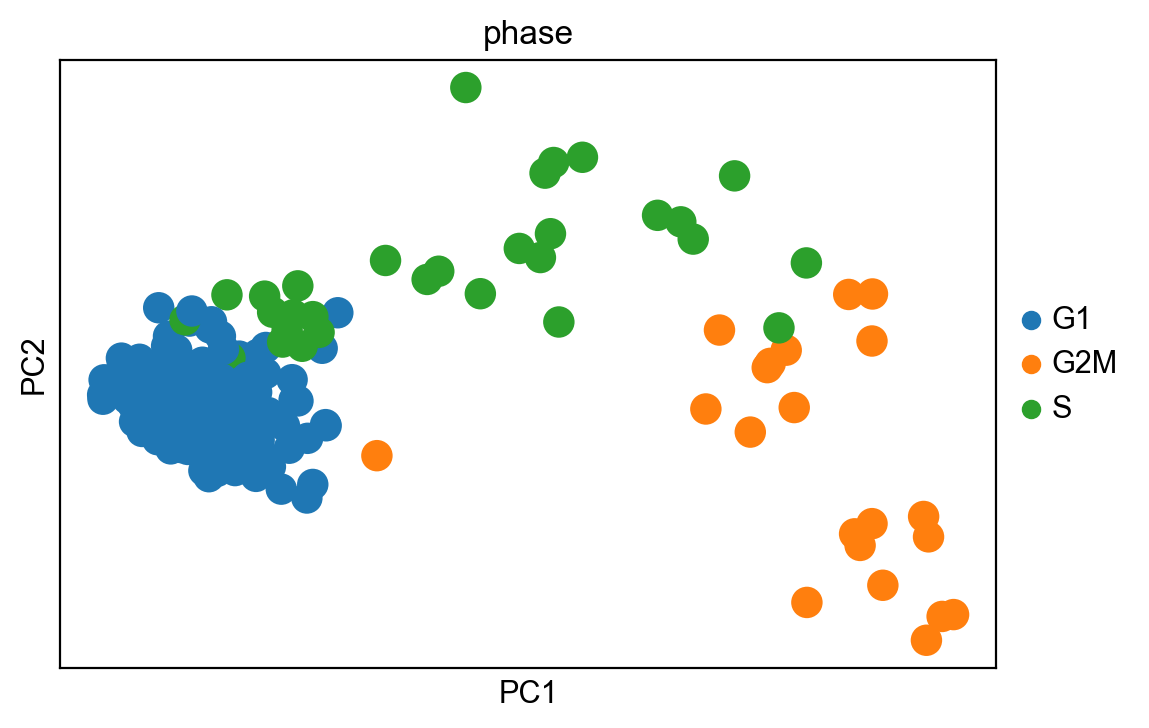

regressing out ['S_score', 'G2M_score']
    sparse input is densified and may lead to high memory use


... storing 'group' as categorical
... storing 'phase' as categorical


    finished (0:00:01)
computing PCA
    with n_comps=50
    finished (0:00:00)


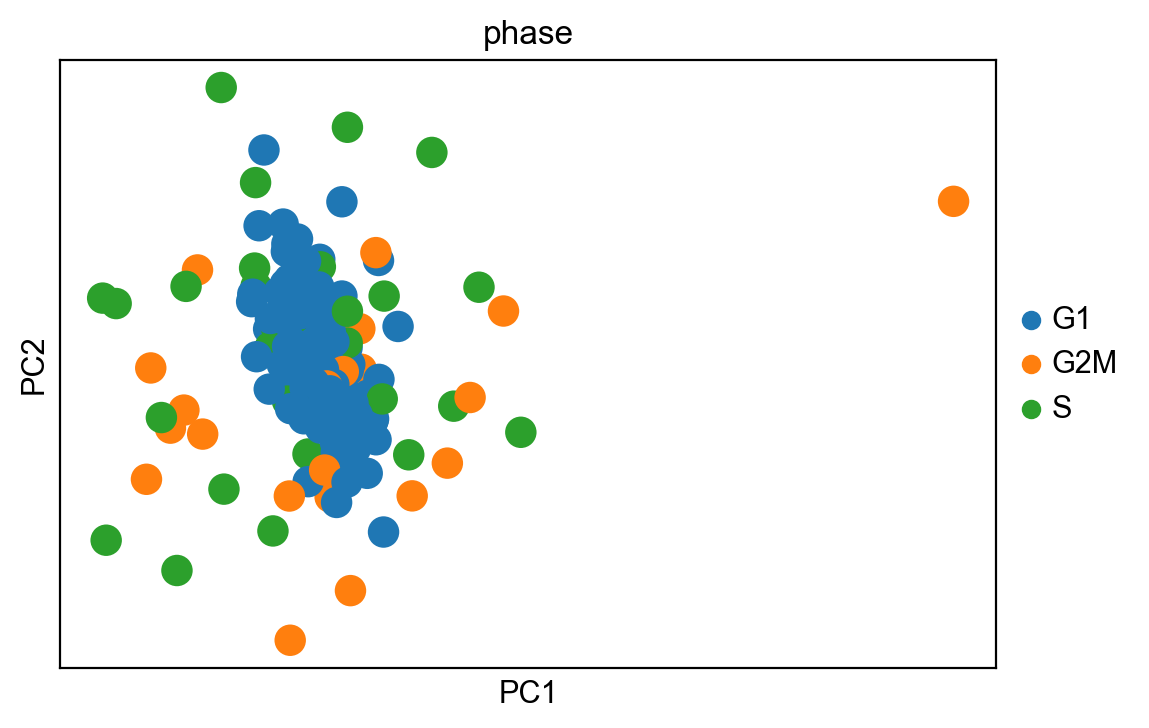

In [6]:
## read cycling genes
cell_cycle_genes = [x.strip() for x in open(f"{oDir}/../../data/external/regev_lab_cell_cycle_genes.txt")]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

## compute score
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

#plot
scv.settings.set_figure_params('scvelo', dpi=100)
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')

## regress and scale
sc.pp.regress_out(adata, ['S_score', 'G2M_score'])
sc.pp.scale(adata)

#plot
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')

In [7]:
## clean some genes
ignoreGenes = pd.read_csv(f"{oDir}/../../data/external/all.gene.ignore.df.txt.gz", compression="gzip", sep="\t", header=0, index_col=0)
flag = [not i in list(ignoreGenes['geneSymbol']) for i in list(adata.var.index)]
adata = adata[:,flag]
#
flag = [not bool(re.match('^RP[LS]', i)) for i in adata.var_names]
adata = adata[:,flag]

In [8]:
sc.pp.highly_variable_genes(adata, n_top_genes=800)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)


Trying to set attribute `.uns` of view, copying.


In [9]:
scv.pp.moments(adata, n_pcs=30, n_neighbors=14)

computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:00)
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [10]:
scv.tl.recover_dynamics(adata, n_jobs=16)
scv.tl.velocity(adata, mode='dynamical', min_r2=0.01)
scv.tl.velocity_graph(adata)

recovering dynamics (using 16/64 cores)



    finished (0:00:03) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_UMAP', embedded velocity vectors (adata.obsm)


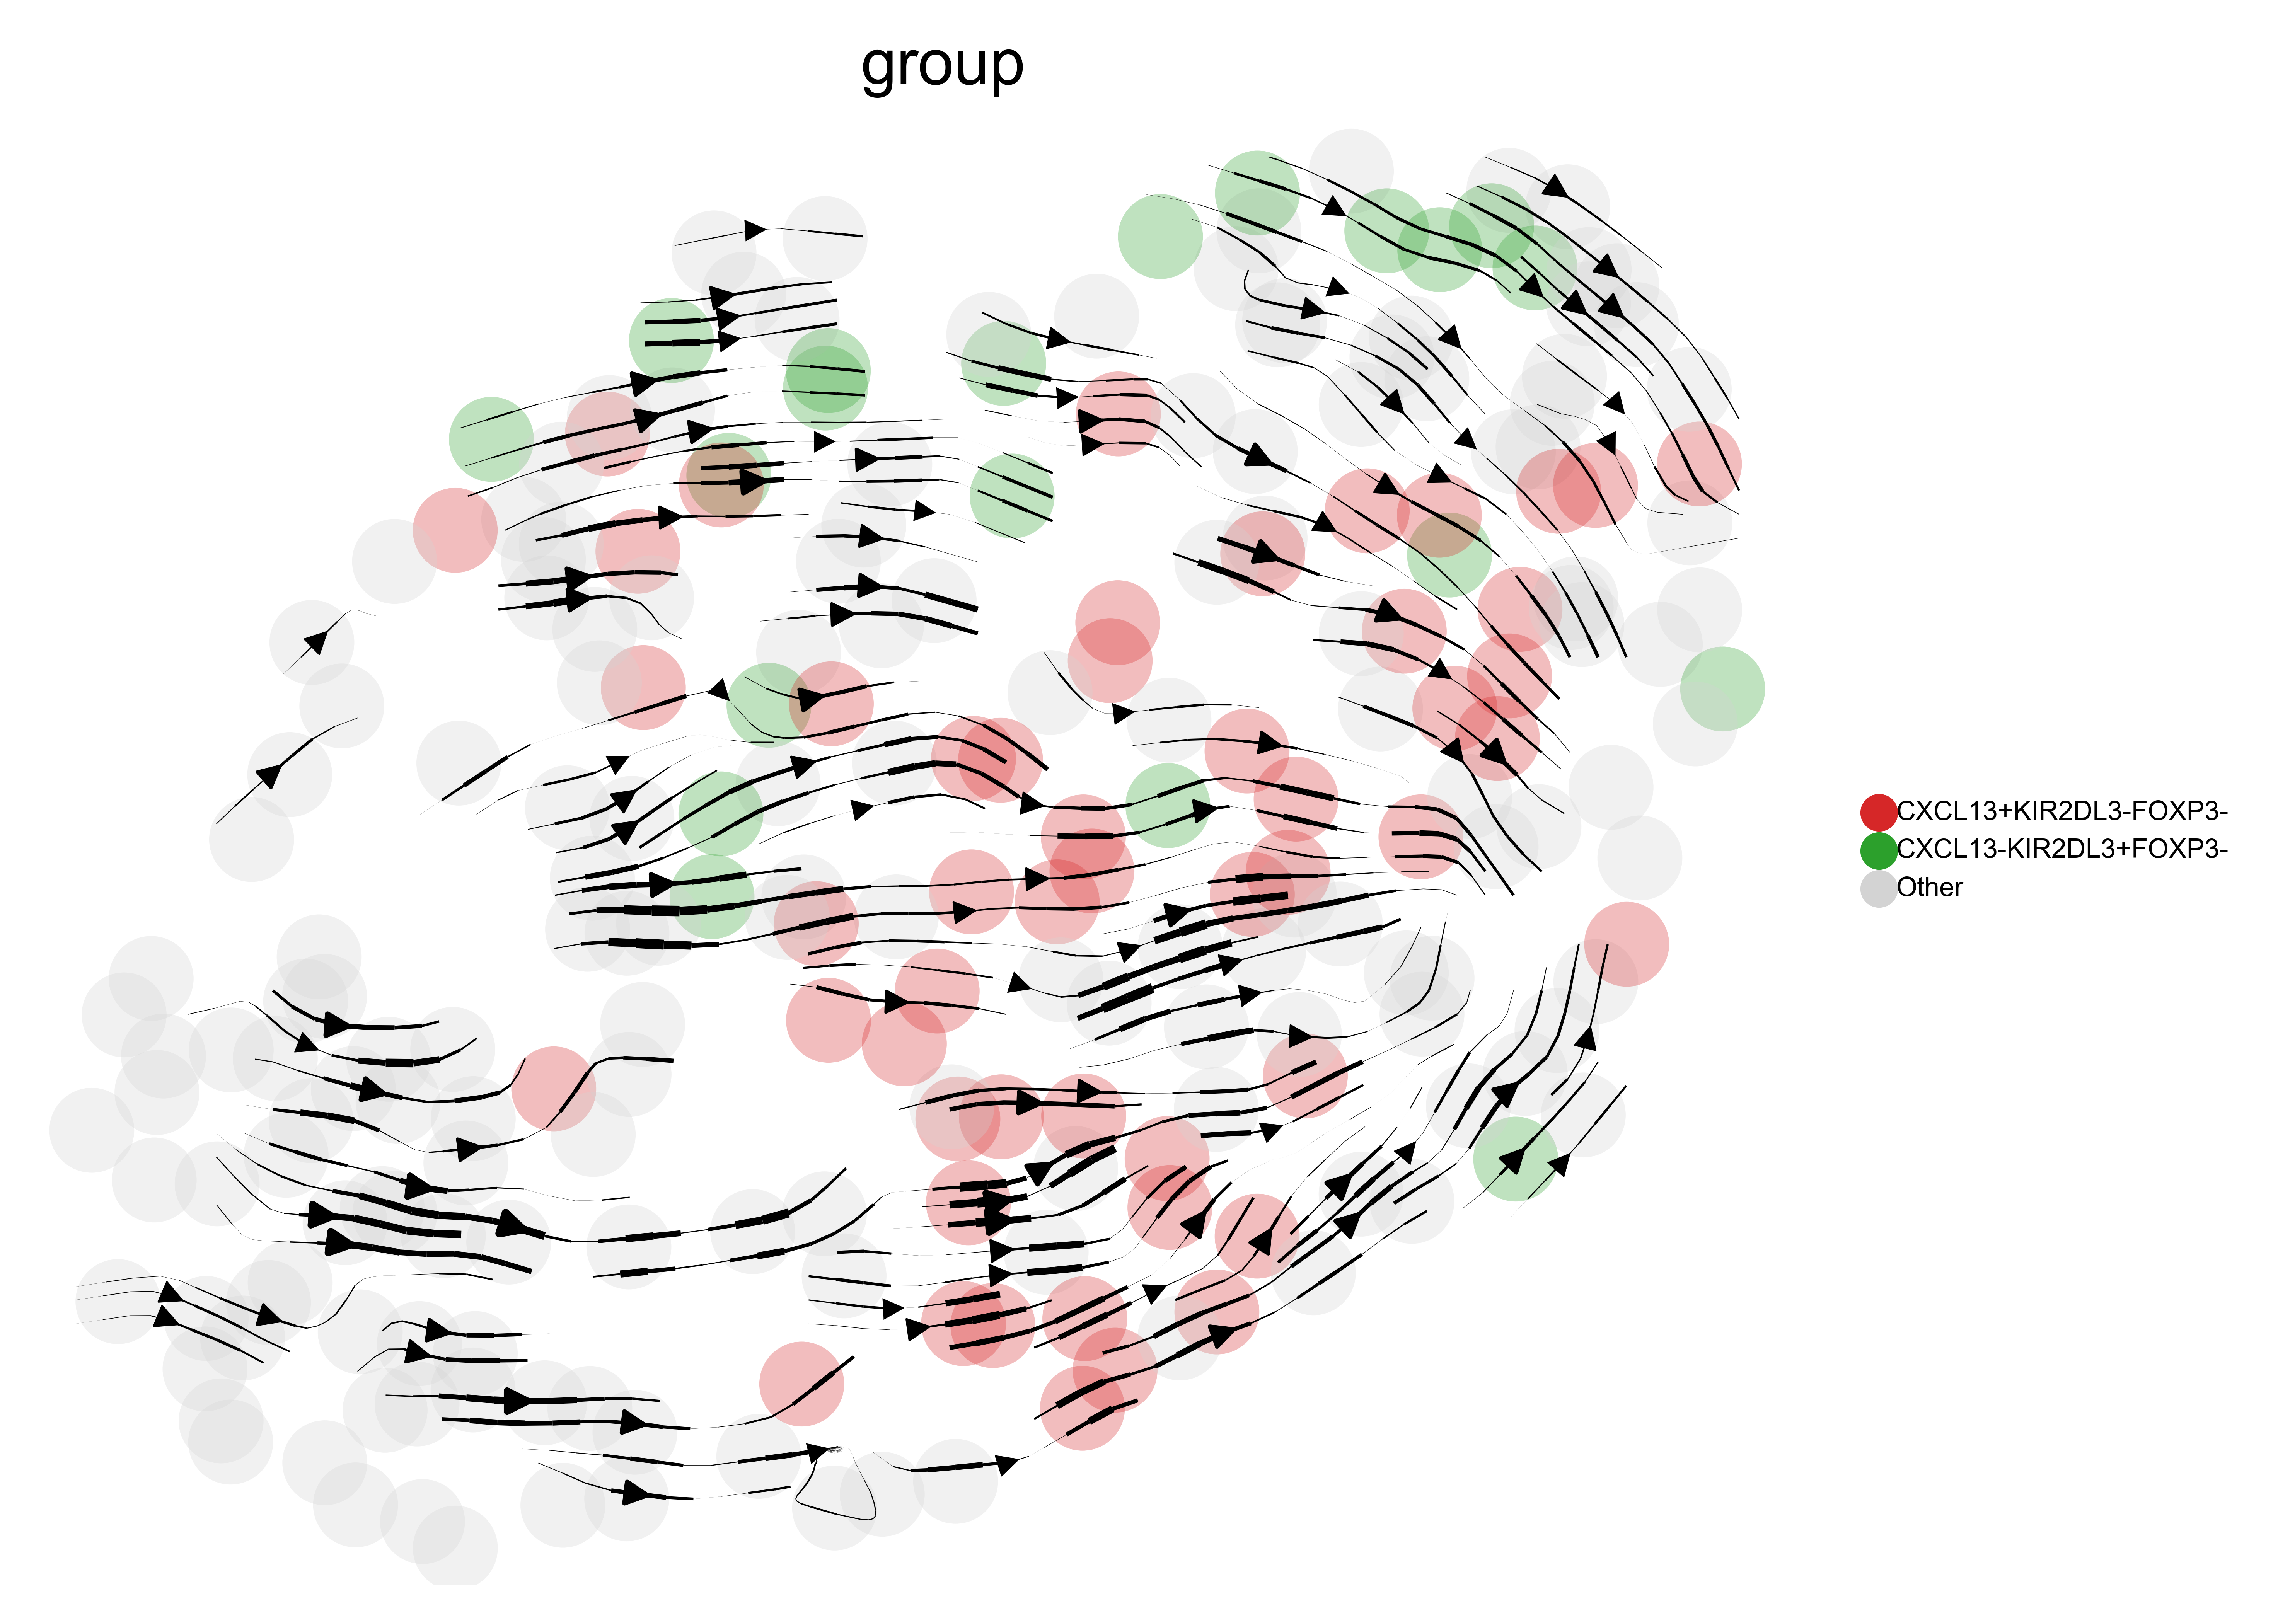

In [11]:
adata.uns['group_colors'] = ['#d62728','#2ca02c','lightgrey']
scv.settings.set_figure_params('scvelo', dpi=500)
scv.pl.velocity_embedding_stream(adata, basis='UMAP',color='group',
                                 legend_loc='right margin',legend_fontsize=5, size=1000,
                                 xlim=[-3.5,3.5], ylim=[-3,3],
                                 figsize=(6,5))

saving figure to file ./figures/scvelo_.CD8_ovTex.umap.pdf


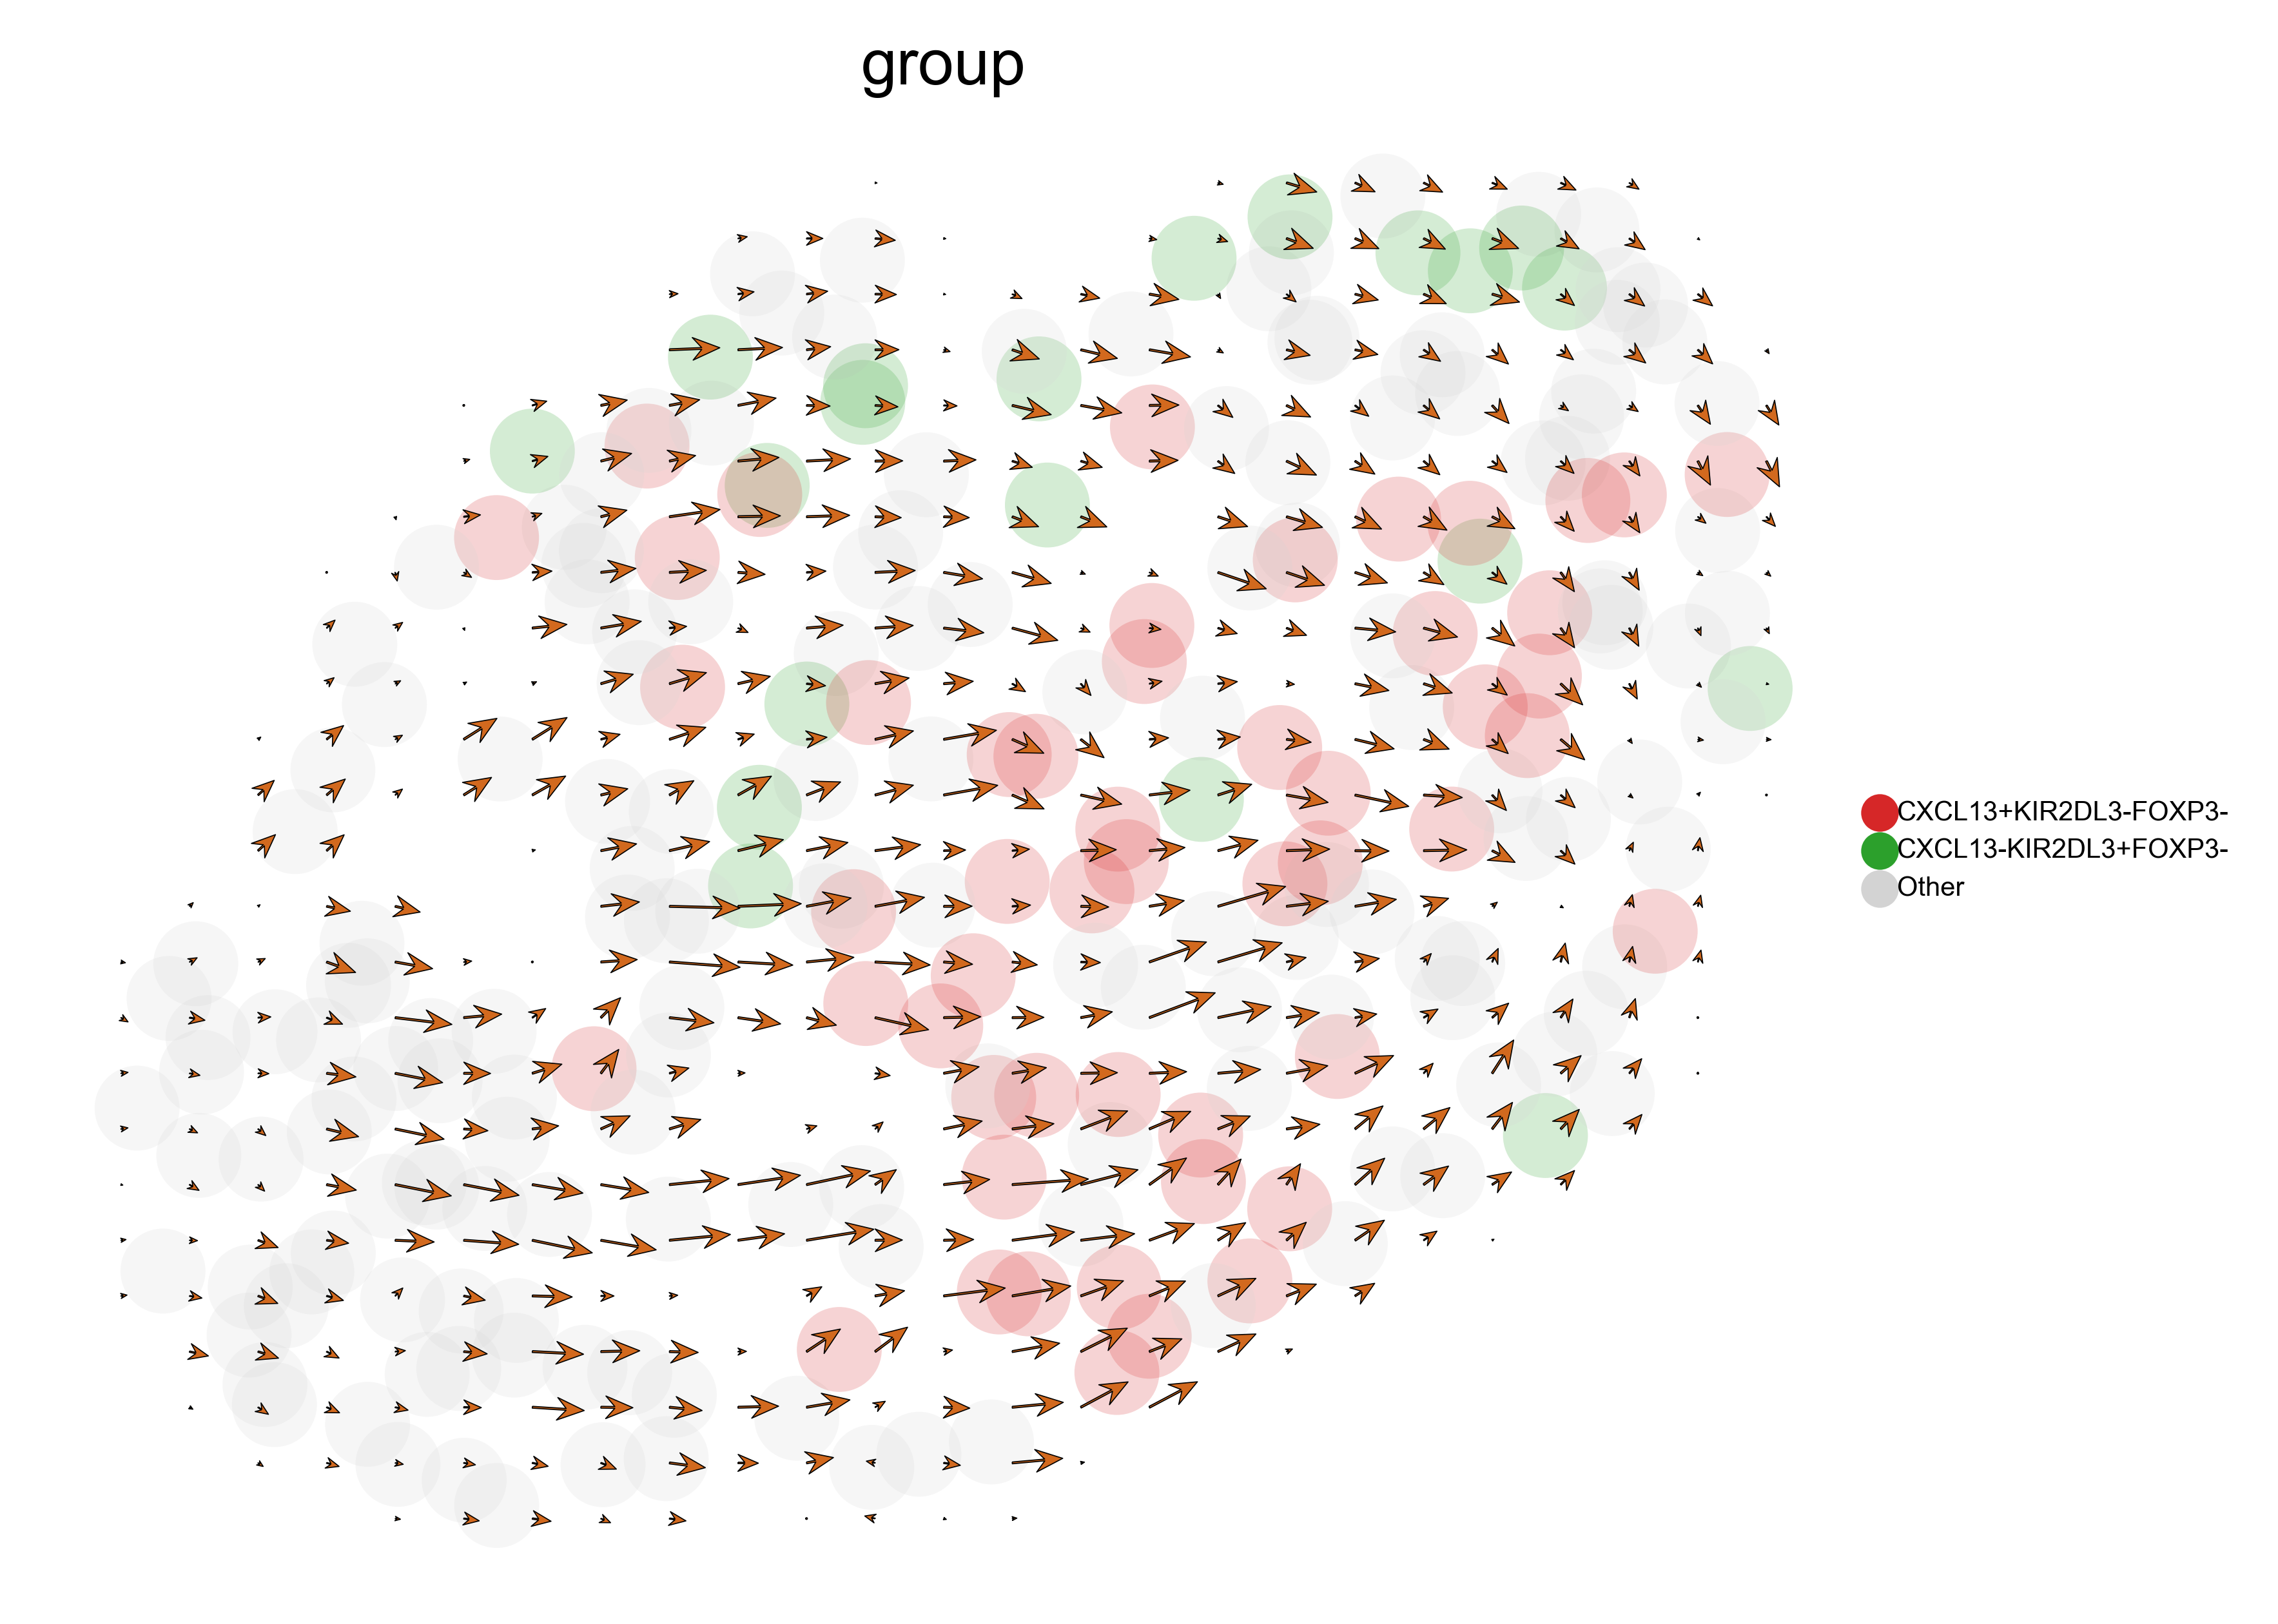

In [12]:
scv.settings.set_figure_params('scvelo', dpi=300)
adata.uns['group_colors'] = ['#d62728','#2ca02c','lightgrey']
scv.pl.velocity_embedding_grid(adata, basis='UMAP',color='group', size=1000,
                               arrow_size=2.5, arrow_length=3.5,
                               arrow_color="#D2691E", density=0.5,
                               legend_loc='right margin',legend_fontsize=5, #palette="Set1",
                               save=f".{stype}_ovTex.umap.pdf", figsize=(6,5),
                              )

In [13]:
adata.write(f"{oDir}/{stype}_ovTex.velo.h5ad")